In [35]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from scipy.stats import randint, uniform
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier,
    StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (
    accuracy_score, mean_squared_error, roc_auc_score, r2_score,
    roc_curve, auc
)
from feature_engine.outliers import Winsorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from skopt import BayesSearchCV

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline
!pip install imbalanced-learn
!pip install scikit-optimize

# Table Of Contents

## 1. [HR Analytics](#part1)
   - [1.1. Load and Sample the Data](#part1.1)
   - [1.2. Build the Model(s)](#part1.2)
   - [1.3. Evaluate and Improve the Model(s)](#part1.3)
   
 ## 2. [Airbnb](#part2)
   - [2.1. Load and Explore the Data](#part2.1)
   - [2.2. Build the Model(s)](#part2.2)
   - [2.3. Evaluate and Improve the Model(s)](#part2.3)

## 1. HR Analytics<a id="part1"></a>

### 1.1 Load and Sample the data<a id="part1.1"></a>

In [3]:
hr_data = pd.read_csv('./new_hr_data_not_sampled.csv')

In [4]:
hr_data.head()

,previous_year_rating,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,KPIs_met_and_awards_won,high_performer,rating_predictor,performance_indicator,likely_candidate
0,5.0,1,0,0.166667,0,0,1,4.793352,4.410019,1.578333
1,5.0,0,0,0.350000,0,0,0,2.434530,2.654530,1.251500
2,3.0,0,0,0.183333,0,0,0,2.710263,2.343596,0.743167
3,1.0,0,0,0.183333,0,0,0,3.012462,2.645796,0.283167
4,3.0,0,0,0.566667,0,0,0,2.718275,3.694942,0.854333


In [5]:
hr_data.shape

(54808, 10)

In [6]:
# Split the HR data into train and test sets
train, test = train_test_split(hr_data, test_size=0.3, random_state=42)

# Downsample the 'not_promoted' subset
not_promoted_sampled = train[train['is_promoted'] == 0].sample(n=10000, random_state=42)

# Combine the downsampled 'not_promoted' subset with the 'promoted' subset
train_balanced = pd.concat([not_promoted_sampled, train[train['is_promoted'] == 1]])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train_balanced.drop('is_promoted', axis=1), train_balanced['is_promoted'])

X_test = test.drop("is_promoted", axis=1)
y_test = test["is_promoted"] 

In [7]:
# Assuming your data is loaded and processed, and the train and test sets are defined as X_train, y_train, X_test, y_test

print("Shape of promoted train set:", X_train[y_train == 1].shape[0])
print("Shape of non-promoted train set:", X_train[y_train == 0].shape[0])

print("Shape of promoted test set:", X_test[y_test == 1].shape[0])
print("Shape of non-promoted test set:", X_test[y_test == 0].shape[0])


Shape of promoted train set: 10000
Shape of non-promoted train set: 10000
Shape of promoted test set: 1333
Shape of non-promoted test set: 15110


In [8]:
# Polynomial
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

poly.fit(X_train)

X_train = poly.transform(X_train)
X_test = poly.transform(X_test)

### 1.2 Build the Model(s)<a id="part1.2"></a>

# Logistics Regression

In [10]:
lg = LogisticRegression(solver='lbfgs', max_iter=10000)

# run enough iterations to let the model converge

# Fit the model to the training set
lg.fit(X_train,y_train)

print(lg.score(X_train, y_train), '(Train Accuracy)')
print(lg.score(X_test, y_test), '(Test Accuracy)')

0.78925 (Train Accuracy)
0.6995682053153317 (Test Accuracy)


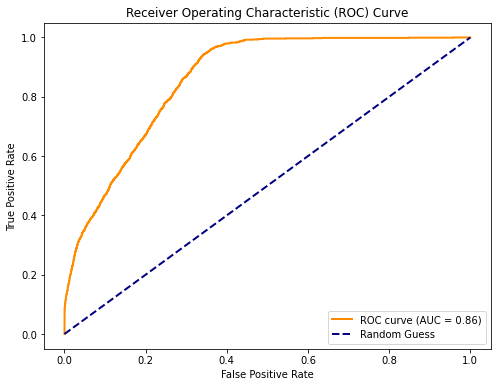

In [13]:
# Make predictions on the test set
y_prob = lg.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# MLP Classifier

In [18]:
mlp = MLPClassifier(max_iter= 1000)
# Fit the model to the training set
mlp.fit(X_train,y_train)

# Calculated the fitted values for training set
y_fitted = mlp.predict(X_train) # returns 0 or 1
y_fitted_prob = mlp.predict_proba(X_train)[:,0] # returns probabilities

# calculated the training accuracy
print(mlp.score(X_train, y_train), '(Train Accuracy)')
# calculated the testing accuracy
print(mlp.score(X_test, y_test), '(Test Accuracy)')

0.81095 (Train Accuracy)
0.7280909809645442 (Test Accuracy)


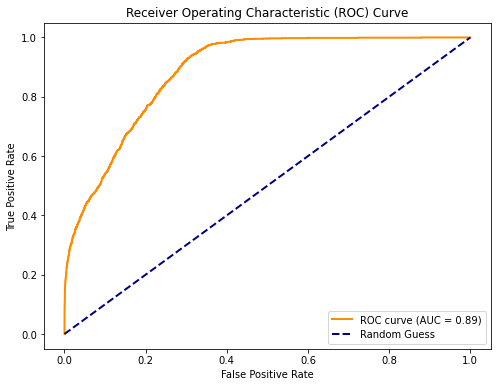

In [20]:
# Make predictions on the test set
y_prob = mlp.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Decision Tree

In [21]:
# Build Descision tree Model and Evaluate both training and testing accuracy
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

print('training accuracy is: ', dt.score(X_train,y_train))
print('testing accuracy is: ', dt.score(X_test,y_test))

training accuracy is:  0.9923
testing accuracy is:  0.8083683026211762


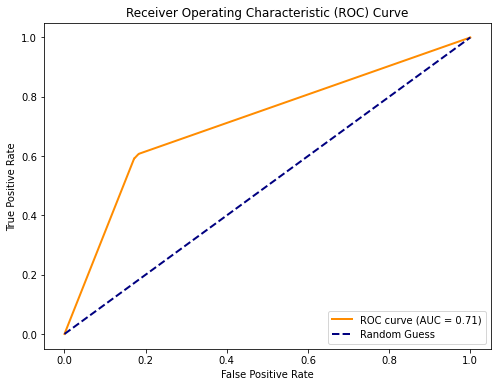

In [22]:
# Make predictions on the test set
y_prob = dt.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Random Forest

In [23]:
#Task 1: Build Random Forest Model and Evaluate both training and testing accuracy
rf = RandomForestClassifier(n_estimators=100, random_state=4)
rf.fit(X_train, y_train)

print('training accuracy is: ', rf.score(X_train,y_train))
print('testing accuracy is: ', rf.score(X_test,y_test))

training accuracy is:  0.9923
testing accuracy is:  0.8140242048288026


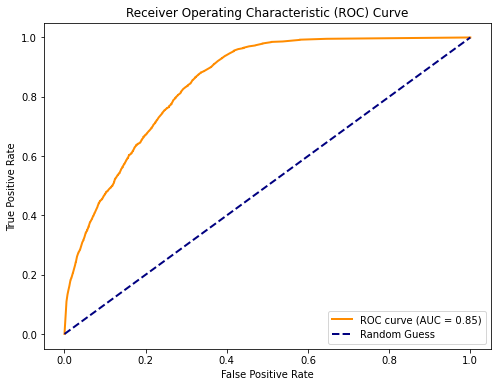

In [24]:
# Make predictions on the test set
y_prob = rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# ADA Boost

In [25]:
#Task 2: Build Ada Boost Model and Evaluate both training and testing accuracy
ada = AdaBoostClassifier(n_estimators=100, random_state=4)
ada.fit(X_train, y_train)

print('training accuracy is: ', ada.score(X_train,y_train))
print('testing accuracy is: ', ada.score(X_test,y_test))

training accuracy is:  0.7777
testing accuracy is:  0.7122179650915283


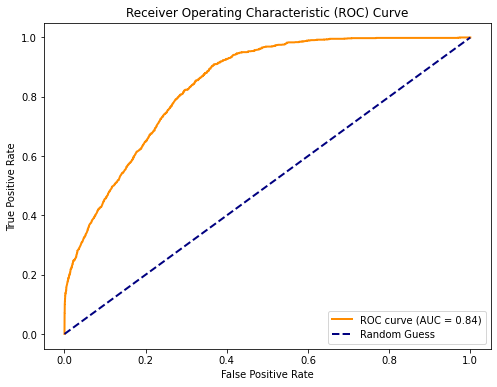

In [26]:
# Make predictions on the test set
y_prob = ada.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# XG Boost

In [27]:
# Task 3: Build XGBoost Model and Evaluate both training and testing accuracy 
xgb = XGBClassifier(n_estimators=100, random_state=4)
xgb.fit(X_train, y_train)

print('training accuracy is: ', xgb.score(X_train,y_train))
print('testing accuracy is: ', xgb.score(X_test,y_test))

training accuracy is:  0.9223
testing accuracy is:  0.800340570455513


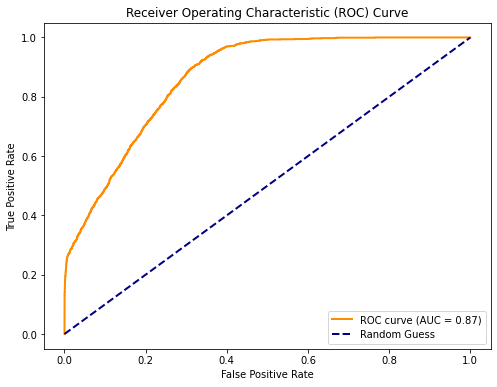

In [28]:
# Make predictions on the test set
y_prob = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# SVM

In [29]:
from sklearn.svm import SVC

# Example SVM model with probability=True
svm = SVC(probability=True, kernel='linear')  # You can adjust other parameters as needed

# Fit the model on your training data
svm.fit(X_train, y_train)

# Now you can use predict_proba without encountering the AttributeError
y_prob = svm.predict_proba(X_test)[:, 1]

print('training accuracy is: ', svm.score(X_train,y_train))
print('testing accuracy is: ', svm.score(X_test,y_test))

training accuracy is:  0.79445
testing accuracy is:  0.678525816456851


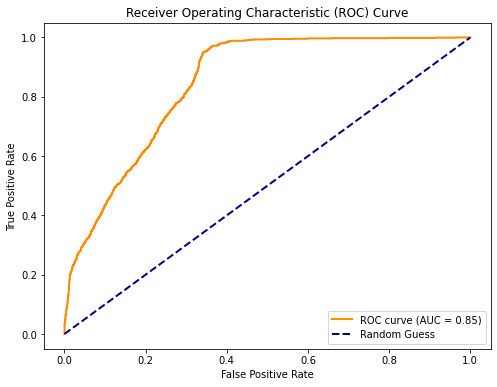

In [30]:
# Make predictions on the test set
y_prob = svm.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 1.3 Evaluate and Improve the Model(s)<a id="part1.3"></a>

In [166]:
def display_classification_metrics(y_true, y_pred):
    # Precision
    precision = precision_score(y_true, y_pred, average='weighted')
    
    # Recall
    recall = recall_score(y_true, y_pred, average='weighted')
    
    # F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Derived Metrics
    true_positive_rate = tp / (tp + fn)
    true_negative_rate = tn / (tn + fp)
    false_positive_rate = fp / (fp + tn)
    
    # Display Metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nConfusion Matrix:")
    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    
    print("\nDerived Metrics:")
    print("True Positive Rate (Recall):", true_positive_rate)
    print("True Negative Rate (Specificity):", true_negative_rate)
    print("False Positive Rate:", false_positive_rate)

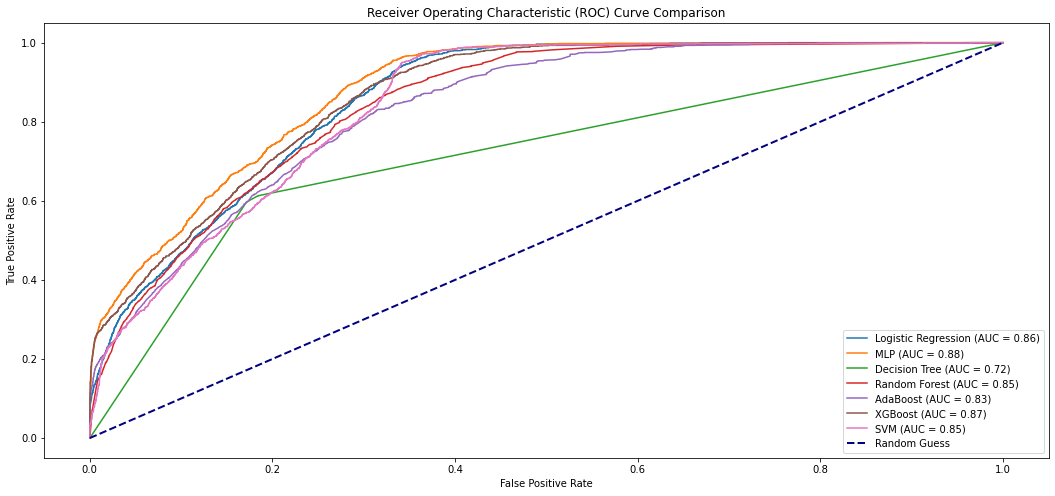

In [31]:
# List of models
models = [
    ('Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=10000)),
    ('MLP', MLPClassifier(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('XGBoost', XGBClassifier()),
    ('SVM', SVC(probability=True, kernel='linear'))
]

# Plot ROC curves for each model
plt.figure(figsize=(18, 8))
for name, model in models:
    model.fit(X_train, y_train)  # Make sure to replace X_train and y_train with your actual training data
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# Logistic Regression

In [10]:
# Define the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=10000)

# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l2'],
    'C': [1, 10, 100, 1000, 10000, 100000, 1000000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Access the best mean test score and corresponding hyperparameters
best_mean_test_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Mean Test Score:", best_mean_test_score)
print("Best Hyperparameters:", best_params)

print(grid_search.score(X_train, y_train), '(Train Accuracy)')

# calculated the testing accuracy
print(grid_search.score(X_test, y_test), '(Test Accuracy)')

Best Mean Test Score: 0.8640597
Best Hyperparameters: {'C': 10000, 'penalty': 'l2'}
0.865020315 (Train Accuracy)
0.866708627851867 (Test Accuracy)


In [13]:
# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     15110
           1       0.20      0.92      0.33      1333

    accuracy                           0.69     16443
   macro avg       0.59      0.80      0.56     16443
weighted avg       0.93      0.69      0.76     16443



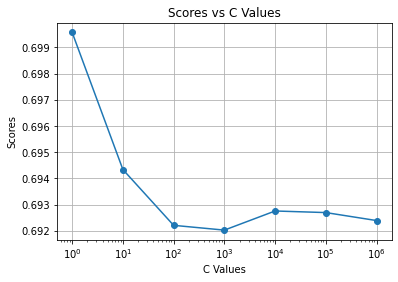

In [33]:
# Create lists to store results
C_values = []
scores = []

# Iterate over C values
for C_val in param_grid['C']:
    # Set the current C value
    logreg.set_params(C=C_val)
    
    # Fit the logistic regression model
    logreg.fit(X_train, y_train)
    
    # Calculate the score (you can replace this with your own scoring metric)
    score = logreg.score(X_test, y_test)
    
    # Append the results to lists
    C_values.append(C_val)
    scores.append(score)

# Create a plot
plt.plot(C_values, scores, marker='o')
plt.xscale('log')  # Since C values are in a wide range, use a logarithmic scale for better visualization
plt.title('Scores vs C Values')
plt.xlabel('C Values')
plt.ylabel('Scores')
plt.grid(True)
plt.show()

In [36]:
# Define the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=10000)

# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l2'],
    'C': [1]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Access the best mean test score and corresponding hyperparameters
best_mean_test_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Mean Test Score:", best_mean_test_score)
print("Best Hyperparameters:", best_params)

print(grid_search.score(X_train, y_train), '(Train Accuracy)')

# calculated the testing accuracy
print(grid_search.score(X_test, y_test), '(Test Accuracy)')

Best Mean Test Score: 0.85720925
Best Hyperparameters: {'C': 1, 'penalty': 'l2'}
0.859241165 (Train Accuracy)
0.8601865141996949 (Test Accuracy)


# ADA Boost

In [154]:
# base_classifier = DecisionTreeClassifier(max_depth=3)
# ada = AdaBoostClassifier(base_classifier)

# # Define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [200, 800],
#     'learning_rate': [0.001, 0.01, 0.1,]
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='roc_auc')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Access the best mean test score and corresponding hyperparameters
# best_mean_test_score = grid_search.best_score_
# best_params = grid_search.best_params_

# print("Best Mean Test Score:", best_mean_test_score)
# print("Best Hyperparameters:", best_params)

# print(grid_search.score(X_train, y_train), '(Train Accuracy)')

# # calculated the testing accuracy
# print(grid_search.score(X_test, y_test), '(Test Accuracy)')

In [155]:
# base_classifier = DecisionTreeClassifier(max_depth=3)
# ada = AdaBoostClassifier(base_classifier)

# # Define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [50, 100, 200, 400, 800],
#     'learning_rate': [0.001, 0.01, 0.1, 1, 2]
# }

# # Create lists to store results
# estimators_values = []
# learning_rate_values = []
# scores = []

# # Iterate over n_estimators values
# for n_estimators_val in param_grid['n_estimators']:
#     # Set the current n_estimators value
#     ada.set_params(n_estimators=n_estimators_val)

#     # Fit the AdaBoostClassifier model
#     ada.fit(X_train, y_train)

#     # Calculate the score (you can replace this with your own scoring metric)
#     score = ada.score(X_test, y_test)

#     # Append the results to lists
#     estimators_values.append(n_estimators_val)
#     learning_rate_values.append(grid_search.best_params['learning_rate'])  # use the best learning_rate
#     scores.append(score)

# # Create a plot for n_estimators
# plt.figure(figsize=(12, 5))
# plt.subplot(1)
# plt.plot(estimators_values, scores, marker='o')
# plt.title('Scores vs n_estimators')
# plt.xlabel('n_estimators')
# plt.ylabel('Scores')
# plt.grid(True)

# # Iterate over learning_rate values
# for learning_rate_val in param_grid['learning_rate']:
#     # Set the current learning_rate value
#     ada.set_params(learning_rate=learning_rate_val)

#     # Fit the AdaBoostClassifier model
#     ada.fit(X_train, y_train)

#     # Calculate the score (you can replace this with your own scoring metric)
#     score = ada.score(X_test, y_test)

#     # Append the results to lists
#     learning_rate_values.append(learning_rate_val)
#     estimators_values.append(grid_search.best_params_['n_estimators'])  # use the best n_estimators
#     scores.append(score)

# # Create a plot for learning_rate
# plt.subplot(2)
# plt.plot(learning_rate_values, scores, marker='o')
# plt.xscale('log')  # Since learning_rate values are in a wide range, use a logarithmic scale for better visualization
# plt.title('Scores vs Learning Rate')
# plt.xlabel('Learning Rate')
# plt.ylabel('Scores')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [156]:
# base_classifier = DecisionTreeClassifier(max_depth=3)
# ada = AdaBoostClassifier(base_classifier)

# # Define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [50, 100, 200, 400,800],
#     'learning_rate': [0.001, 0.01, 0.1, 1, 2]
# }

# # Create a GridSearchCV object
# grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='roc_auc')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Access the best mean test score and corresponding hyperparameters
# best_mean_test_score = grid_search.best_score_
# best_params = grid_search.best_params_

# print("Best Mean Test Score:", best_mean_test_score)
# print("Best Hyperparameters:", best_params)

# print(grid_search.score(X_train, y_train), '(Train Accuracy)')

# # calculated the testing accuracy
# print(grid_search.score(X_test, y_test), '(Test Accuracy)')

# MLP Classifier

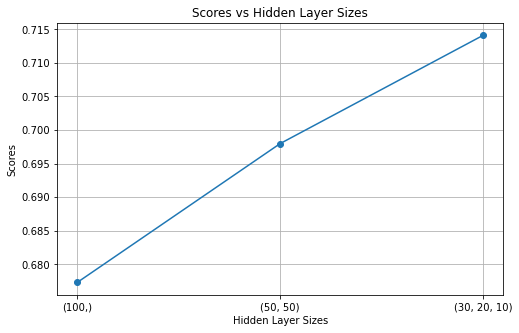

In [40]:
mlp = MLPClassifier(max_iter=500, validation_fraction=0.1)

# Define the hyperparameter grid to search
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (30, 20, 10)],
    'activation': ['relu', 'tanh'],
    'alpha': [0, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Create lists to store results
hidden_layer_sizes_values = []
scores_per_hidden_size = []

# Iterate over hidden layer sizes
for hidden_layer_size_val in param_grid['hidden_layer_sizes']:
    # Set the current hidden layer size
    mlp.set_params(hidden_layer_sizes=hidden_layer_size_val)

    # Fit the MLPClassifier model
    mlp.fit(X_train, y_train)

    # Calculate the score (you can replace this with your own scoring metric)
    score = mlp.score(X_test, y_test)

    # Append the results to lists
    hidden_layer_sizes_values.append(str(hidden_layer_size_val))
    scores_per_hidden_size.append(score)

# Create a plot for hidden_layer_sizes
plt.figure(figsize=(8, 5))
plt.plot(hidden_layer_sizes_values, scores_per_hidden_size, marker='o')
plt.title('Scores vs Hidden Layer Sizes')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Scores')
plt.grid(True)

plt.show()

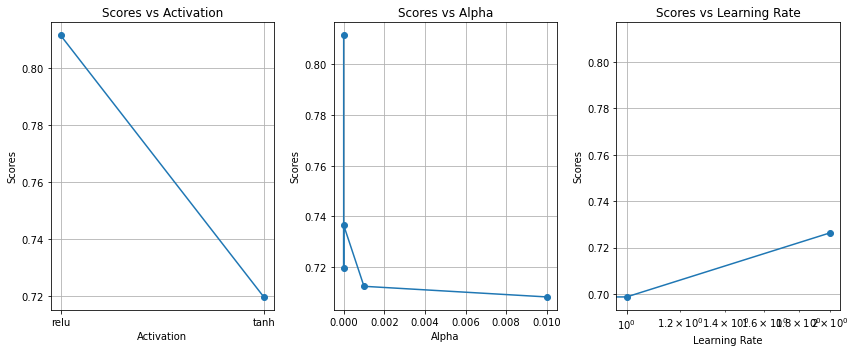

In [41]:
mlp = MLPClassifier(max_iter=500, validation_fraction=0.1)

# Define the hyperparameter grid to search
param_grid = {
    'activation': ['relu', 'tanh'],
    'alpha': [0, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Create lists to store results
activation_values = []
alpha_values = []
learning_rate_values = []
scores = []

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Iterate over activation values
for activation_val in param_grid['activation']:
    # Set the current activation value
    mlp.set_params(activation=activation_val)

    # Fit the MLPClassifier model
    mlp.fit(X_train, y_train)

    # Calculate the score (you can replace this with your own scoring metric)
    score = mlp.score(X_test, y_test)

    # Append the results to lists
    activation_values.append(activation_val)
    alpha_values.append(random_search.best_params_['alpha'])
    learning_rate_values.append(random_search.best_params_['learning_rate'])
    scores.append(score)

# Create a plot for activation
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(activation_values, scores, marker='o')
plt.title('Scores vs Activation')
plt.xlabel('Activation')
plt.ylabel('Scores')
plt.grid(True)

# Iterate over alpha values
for alpha_val in param_grid['alpha']:
    # Set the current alpha value
    mlp.set_params(alpha=alpha_val)

    # Fit the MLPClassifier model
    mlp.fit(X_train, y_train)

    # Calculate the score (you can replace this with your own scoring metric)
    score = mlp.score(X_test, y_test)

    # Append the results to lists
    alpha_values.append(alpha_val)
    activation_values.append(random_search.best_params_['activation'])
    learning_rate_values.append(random_search.best_params_['learning_rate'])
    scores.append(score)

# Create a plot for alpha
plt.subplot(1, 3, 2)
plt.plot(alpha_values, scores, marker='o')
plt.title('Scores vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Scores')
plt.grid(True)

# Iterate over learning_rate values
for learning_rate_val in param_grid['learning_rate']:
    # Set the current learning_rate value
    mlp.set_params(learning_rate=learning_rate_val)

    # Fit the MLPClassifier model
    mlp.fit(X_train, y_train)

    # Calculate the score (you can replace this with your own scoring metric)
    score = mlp.score(X_test, y_test)

    # Append the results to lists
    learning_rate_values.append(learning_rate_val)
    activation_values.append(random_search.best_params_['activation'])
    alpha_values.append(random_search.best_params_['alpha'])
    scores.append(score)

# Create a plot for learning_rate
plt.subplot(1, 3, 3)
plt.plot(learning_rate_values, scores, marker='o')
plt.xscale('log')  # Since learning_rate values are in a wide range, use a logarithmic scale for better visualization
plt.title('Scores vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Scores')
plt.grid(True)

plt.tight_layout()
plt.show()


In [164]:
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
    'activation': ['logistic','relu'],
    'max_iter': [2000, 2500, 3000],
    'solver': ['sgd','adam']
}

mlp = MLPClassifier(random_state=2)

gs = GridSearchCV(mlp, param_grid=param_grid, scoring='accuracy', cv=4, n_jobs=-1)
gs.fit(X_train, y_train)

print("Best Parameters", gs.best_params_)
print("Best Accuracy: {:.2f}%".format(gs.best_score_ * 100))
mlp = MLPClassifier(activation ='relu', hidden_layer_sizes=(20,), max_iter= 2000, solver = 'adam', random_state=2)
# Fit the model to the training set
mlp.fit(X_train,y_train)

print(mlp.score(X_train, y_train), '(Train Accuracy)')

print(mlp.score(X_test, y_test), '(Test Accuracy)')

Best Parameters {'activation': 'relu', 'hidden_layer_sizes': (30,), 'max_iter': 2000, 'solver': 'adam'}
Best Accuracy: 80.56%
0.8065 (Train Accuracy)
0.6880131362889984 (Test Accuracy)


In [14]:
# Define the MLPClassifier model
mlp = MLPClassifier(max_iter=500, validation_fraction=0.1)

# Define the hyperparameter grid to search
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (30, 20, 10)],
    'activation': ['relu', 'tanh'],
    'alpha': [0, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}


random_search = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc', n_jobs=-1)
random_search.fit(X_train, y_train)

best_mean_test_score = random_search.best_score_
best_params = random_search.best_params_
print("Best Mean Test Score:", best_mean_test_score)
print("Best Hyperparameters:", best_params)

print(random_search.score(X_train, y_train), '(Train Accuracy)')

# calculated the testing accuracy
print(random_search.score(X_test, y_test), '(Test Accuracy)')

Best Mean Test Score: 0.8990781
Best Hyperparameters: {'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 0, 'activation': 'tanh'}
0.912941445 (Train Accuracy)
0.890069795741457 (Test Accuracy)


In [15]:
# Get the best estimator from the grid search
best_model = random_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83     15110
           1       0.22      0.91      0.35      1333

    accuracy                           0.73     16443
   macro avg       0.60      0.81      0.59     16443
weighted avg       0.93      0.73      0.79     16443



# Random Forest

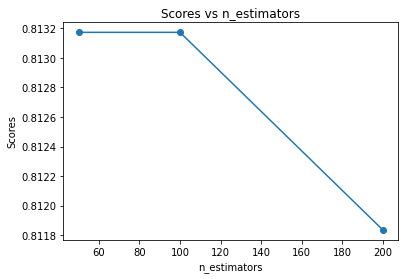

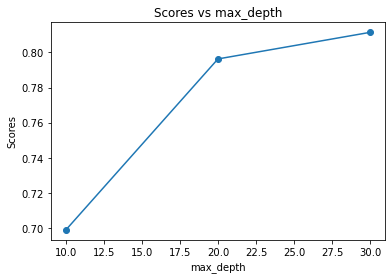

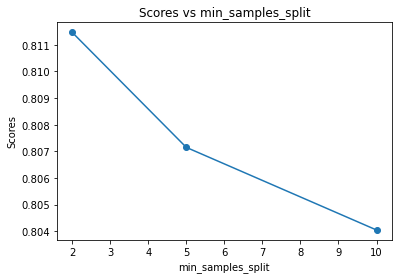

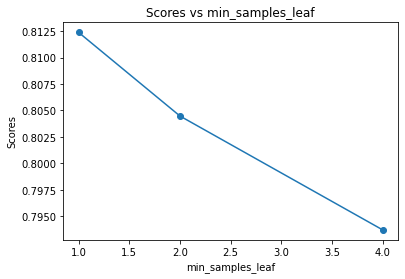

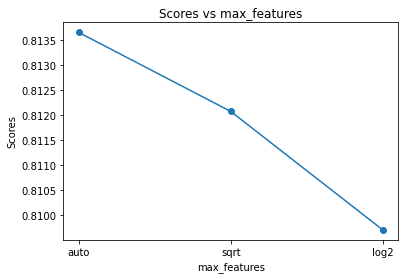

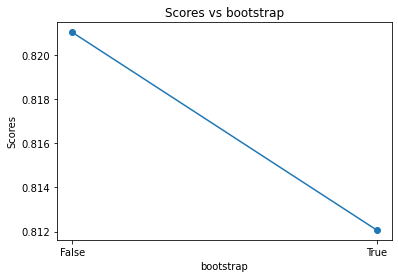

In [45]:
# Define the RandomForestClassifier model
rf = RandomForestClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Function to plot hyperparameter vs scores
def plot_hyperparameter(param_values, scores, param_name, is_binary=False):
    plt.plot(param_values, scores, marker='o')
    plt.title(f'Scores vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Scores')

    # Convert values to "True" and "False" if it's a binary parameter
    if is_binary:
        plt.xticks(param_values, ['True' if val else 'False' for val in param_values])

    plt.show()

# Iterate over each hyperparameter
for param_name in param_grid:
    param_values = param_grid[param_name]
    scores = []

    # Check if the parameter is binary
    is_binary = all(isinstance(val, bool) for val in param_values)

    # Fix other hyperparameters to their best values
    fixed_params = random_search.best_params_.copy()
    del fixed_params[param_name]

    for param_val in param_values:
        # Set the current hyperparameter value
        param_setting = {param_name: param_val, **fixed_params}
        rf.set_params(**param_setting)

        # Calculate the score (you can replace this with your own scoring metric)
        rf.fit(X_train, y_train)
        score = rf.score(X_test, y_test)
        scores.append(score)

    # Plot the results for the current hyperparameter
    plot_hyperparameter(param_values, scores, param_name, is_binary=is_binary)

In [16]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}


# Create a GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Access the best mean test score and corresponding hyperparameters
best_mean_test_score = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Mean Test Score:", best_mean_test_score)
print("Best Hyperparameters:", best_params)

# Print additional metrics (e.g., training and testing accuracy)
print(grid_search.score(X_train, y_train), '(Train AUC)')
print(grid_search.score(X_test, y_test), '(Test AUC)')

Best Mean Test Score: 0.9294988499999999
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.9989870949999999 (Train AUC)
0.851491090840215 (Test AUC)


In [17]:
# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89     15110
           1       0.24      0.63      0.35      1333

    accuracy                           0.81     16443
   macro avg       0.60      0.73      0.62     16443
weighted avg       0.90      0.81      0.85     16443



In [205]:
rf = RandomForestClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='roc_auc', n_jobs=-1)
random_search.fit(X_train, y_train)

# Access the best mean test score and corresponding hyperparameters
best_mean_test_score = random_search.best_score_
best_params = random_search.best_params_

print("Best Mean Test Score:", best_mean_test_score)
print("Best Hyperparameters:", best_params)

# Print additional metrics (e.g., training and testing accuracy)
print(random_search.score(X_train, y_train), '(Train AUC)')
print(random_search.score(X_test, y_test), '(Test AUC)')

Best Mean Test Score: 0.9288815249999999
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
0.9989159849999999 (Train AUC)
0.8488091331237839 (Test AUC)


# XG Boost

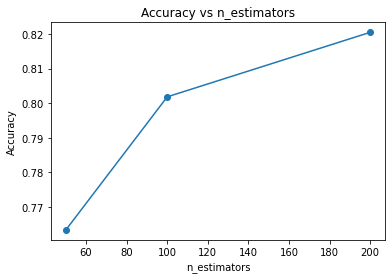

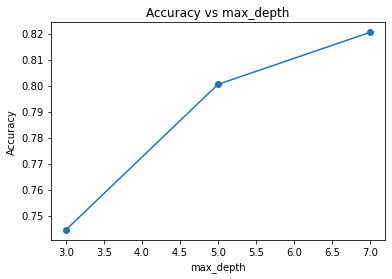

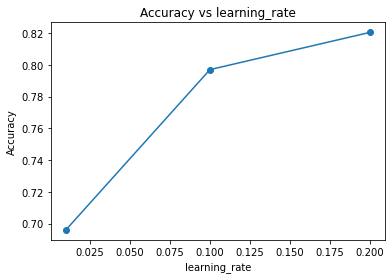

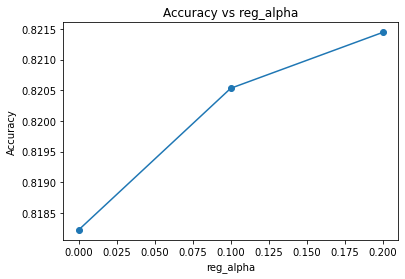

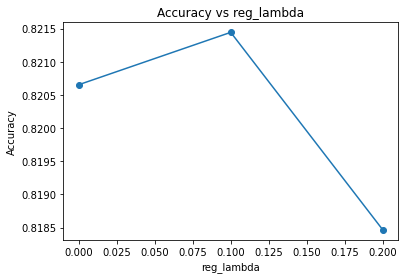

In [48]:
# Create XGBClassifier
bst = XGBClassifier(objective='binary:logistic')

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2]
}

# Use GridSearchCV with cross-validation
grid_search = GridSearchCV(bst, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Function to plot hyperparameter vs accuracy
def plot_hyperparameter(param_values, accuracies, param_name):
    plt.plot(param_values, accuracies, marker='o')
    plt.title(f'Accuracy vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.show()

# Iterate over each hyperparameter
for param_name in param_grid:
    param_values = param_grid[param_name]
    accuracies = []

    for param_val in param_values:
        # Set the current hyperparameter value
        best_params[param_name] = param_val
        bst.set_params(**best_params)

        # Calculate the accuracy
        bst.fit(X_train, y_train)
        preds = bst.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        accuracies.append(accuracy)

    # Plot the results for the current hyperparameter
    plot_hyperparameter(param_values, accuracies, param_name)

In [165]:
# Create XGBClassifier with tuned parameters
bst_tuned = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,  # Adjust as needed
    max_depth=5,  # Reduce to decrease model complexity
    learning_rate=0.1,  # Experiment with lowering the learning rate
    reg_alpha=0.1,  # Add regularization to prevent overfitting
    reg_lambda=0.5  # Add regularization to prevent overfitting
)

# Fit the model
bst_tuned.fit(X_train, y_train)

# Make predictions on the training set
train_preds = bst_tuned.predict(X_train)

# Make predictions on the test set
test_preds = bst_tuned.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.8367
Test Accuracy: 0.724198747187253


In [18]:
# Create XGBClassifier
bst = XGBClassifier(objective='binary:logistic')

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2]
}

# Use GridSearchCV with cross-validation
grid_search = GridSearchCV(bst, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Create a new XGBClassifier with the best parameters
best_bst = XGBClassifier(objective='binary:logistic', **best_params)

# Fit the model with the best parameters
best_bst.fit(X_train, y_train)

# Make predictions on the training set
train_preds = best_bst.predict(X_train)

# Make predictions on the test set
test_preds = best_bst.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Best Parameters:", best_params)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Train Accuracy: 0.96485
Test Accuracy: 0.8205315331752113


In [19]:
# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90     15110
           1       0.26      0.63      0.36      1333

    accuracy                           0.82     16443
   macro avg       0.61      0.74      0.63     16443
weighted avg       0.91      0.82      0.85     16443



In [21]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create the XGBClassifier
bst = XGBClassifier(objective='binary:logistic')

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(bst, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)

# Fit the model
grid_result = grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_result.best_params_

# Create a new XGBClassifier with the best parameters
best_bst = XGBClassifier(objective='binary:logistic', **best_params)

# Fit the model with the best parameters
best_bst.fit(X_train, y_train)

# Make predictions
preds = best_bst.predict(X_test)

print(best_bst.score(X_train, y_train), '(Train Accuracy)')
print(best_bst.score(X_test, y_test), '(Test Accuracy)')

0.9568 (Train Accuracy)
0.8171866447728516 (Test Accuracy)


## 2. Airbnb<a id="part2"></a>

### 2.1 Load and Sample the data<a id="part2.1"></a>

In [129]:
central_listings = pd.read_csv('./central_listings_withcolumns.csv')

In [130]:
central_listings.shape

(6309, 21)

In [131]:
# Subset based on the price column within the range 0 to 250
central_listings = central_listings[(central_listings['price'] >= 20) & (central_listings['price'] <= 150)]

# Print or use the subsetted DataFrame as needed
central_listings.shape

(3705, 21)

In [132]:
X = central_listings.drop('price',axis=1)
y = central_listings['price']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [134]:
# Step 1: Apply PCA
n_components = min(X_train.shape[0], X_train.shape[1]) - 1
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)

# Step 2: Analyze the explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Print the explained variance for each component
print("Explained Variance Ratio for Each Component:")
print(explained_variance_ratio)

# Print the cumulative explained variance
print("\nCumulative Explained Variance:")
print(cumulative_explained_variance)


# You can choose the number of components based on the explained variance

# Step 3: Apply the same transformation to your test set

X_test = pca.transform(X_test)

Explained Variance Ratio for Each Component:
[2.20829895e-01 2.03027010e-01 1.08289263e-01 9.61436752e-02
 8.29753713e-02 7.20637410e-02 5.05628081e-02 3.73740775e-02
 3.68522110e-02 2.92607528e-02 2.27434753e-02 1.81709931e-02
 8.57690243e-03 7.92413691e-03 5.20568768e-03 4.53790086e-31
 2.71062827e-32 4.54225553e-33 1.84152487e-33]

Cumulative Explained Variance:
[0.22082989 0.42385691 0.53214617 0.62828984 0.71126521 0.78332896
 0.83389176 0.87126584 0.90811805 0.9373788  0.96012228 0.97829327
 0.98687018 0.99479431 1.         1.         1.         1.
 1.        ]


In [135]:
# Polynomial
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

poly.fit(X_train)

X_train = poly.transform(X_train)
X_test = poly.transform(X_test)

### 2.2 Build the Model(s)<a id="part2.2"></a>

In [136]:
def train_predict_visualize_regressor(model, X_train, X_test, y_train, y_test):
    try:
        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Scatter plot of predicted vs. actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_test_pred, alpha=0.5)
        plt.title(f'Scatter Plot of Predicted vs. Actual Values ({type(model).__name__})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.show()

        # Residual plot
        residuals = y_test - y_test_pred
        plt.figure(figsize=(10, 6))
        sns.residplot(x=y_test_pred, y=residuals, lowess=True, scatter_kws={'alpha': 0.5})
        plt.title(f'Residual Plot ({type(model).__name__})')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.show()

        # Feature importance plot (if applicable)
        if hasattr(model, 'feature_importances_') and hasattr(model, 'get_params'):
            feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            plt.figure(figsize=(12, 8))
            feature_importance.plot(kind='barh')
            plt.title(f'Feature Importance Plot ({type(model).__name__})')
            plt.xlabel('Feature Importance')
            plt.ylabel('Features')
            plt.show()

    except Exception as e:
        print(f"Error during modeling: {e}")

# Linear regression

In [137]:
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"Linear Regression Train R-squared: {lr_model.score(X_train, y_train)}")
print(f"Linear Regression Test R-squared: {lr_model.score(X_test, y_test)}")
print(f"Linear Regression Train MSE: {mse_train}")
print(f"Linear Regression Test MSE: {mse_test}")

Linear Regression Train R-squared: 0.6798841659470957
Linear Regression Test R-squared: 0.6191132557503194
Linear Regression Train MSE: 449.2036191187813
Linear Regression Test MSE: 532.8628983531925


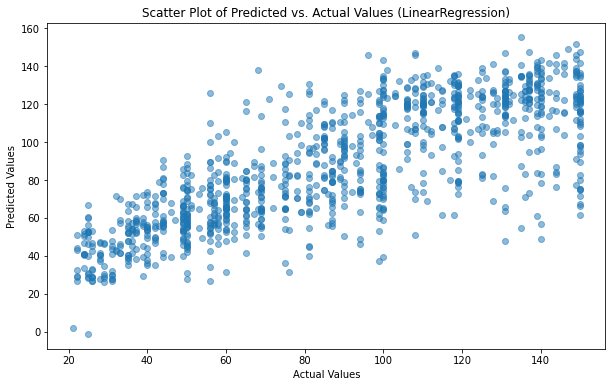

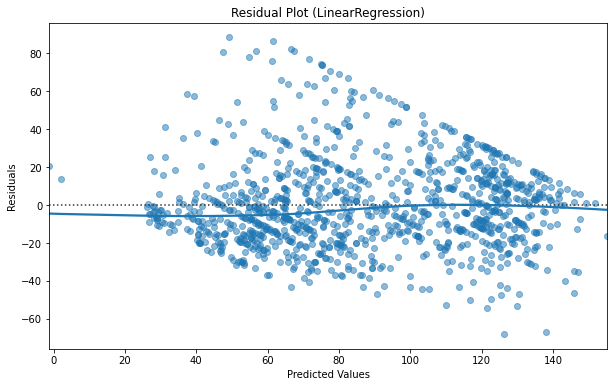

In [89]:
linear_model = LinearRegression()
train_predict_visualize_regressor(linear_model, X_train, X_test, y_train, y_test)

# Lasso 

In [90]:
lasso_model = Lasso()

# Train the model
lasso_model.fit(X_train, y_train)

# Predictions
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"Lasso Train R-squared: {lasso_model.score(X_train, y_train)}")
print(f"Lasso Test R-squared: {lasso_model.score(X_test, y_test)}")
print(f"Lasso Train MSE: {mse_train}")
print(f"Lasso Test MSE: {mse_test}")

Lasso Train R-squared: 0.6413643535600226
Lasso Test R-squared: 0.6166683083243201
Lasso Train MSE: 503.2566752046919
Lasso Test MSE: 536.2833948430496


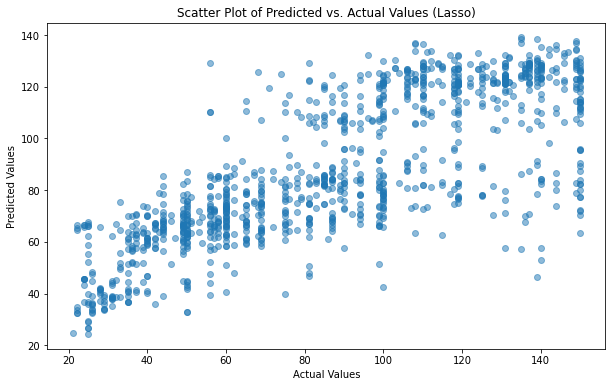

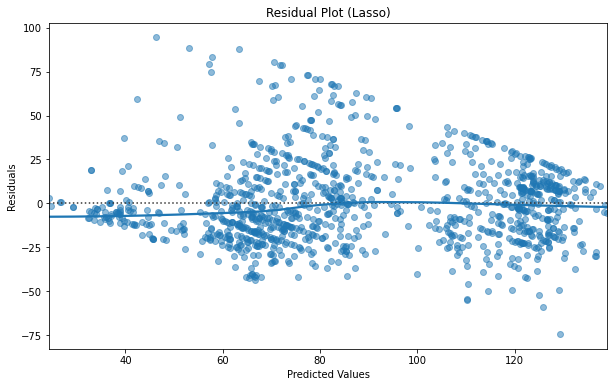

In [91]:
dt_model = Lasso()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

# Ridge

In [92]:
ridge_model = Ridge()

# Train the model
ridge_model.fit(X_train, y_train)

# Predictions
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"Ridge Train R-squared: {ridge_model.score(X_train, y_train)}")
print(f"Ridge Test R-squared: {ridge_model.score(X_test, y_test)}")
print(f"Ridge Train MSE: {mse_train}")
print(f"Ridge Test MSE: {mse_test}")

Ridge Train R-squared: 0.6794712275750123
Ridge Test R-squared: 0.6198318868077701
Ridge Train MSE: 449.7830762760997
Ridge Test MSE: 531.8575290829276


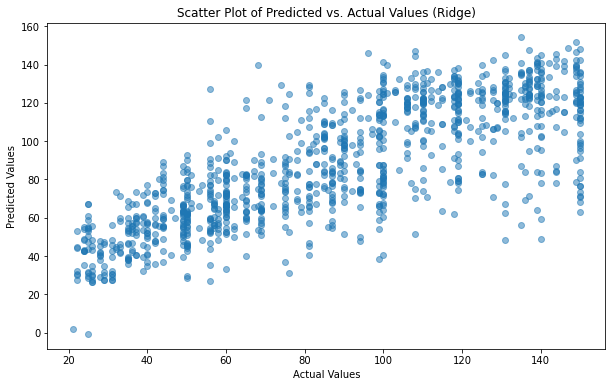

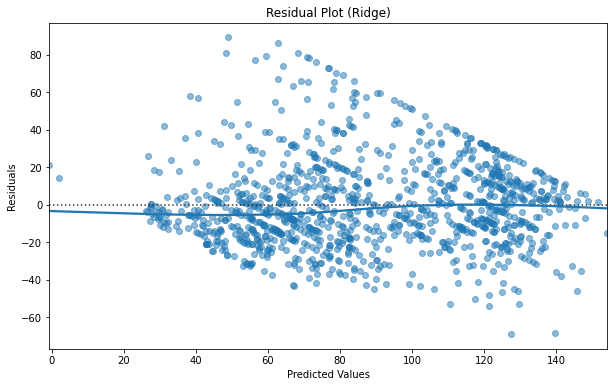

In [93]:
dt_model = Ridge()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

# Decision Tree

In [94]:
DecisionTree_model = DecisionTreeRegressor()

# Train the model
DecisionTree_model.fit(X_train, y_train)

# Predictions
y_train_pred = DecisionTree_model.predict(X_train)
y_test_pred = DecisionTree_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"DecisionTree Train R-squared: {DecisionTree_model.score(X_train, y_train)}")
print(f"DecisionTree Test R-squared: {DecisionTree_model.score(X_test, y_test)}")
print(f"DecisionTree Train MSE: {mse_train}")
print(f"DecisionTree Test MSE: {mse_test}")

DecisionTree Train R-squared: 1.0
DecisionTree Test R-squared: 0.294930489441831
DecisionTree Train MSE: 0.0
DecisionTree Test MSE: 986.3965827338129


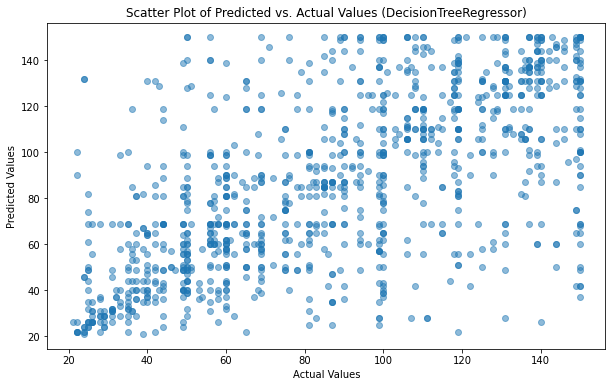

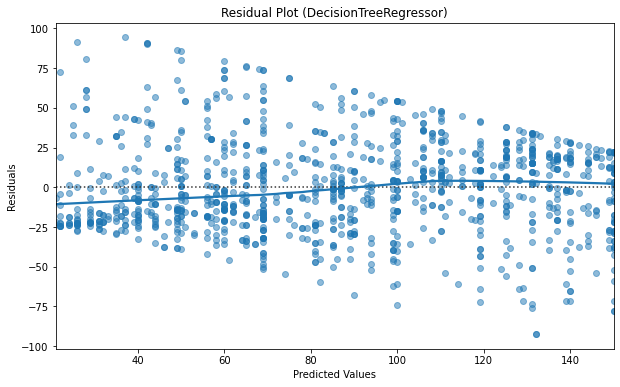

Error during modeling: 'numpy.ndarray' object has no attribute 'columns'


In [95]:
dt_model = DecisionTreeRegressor()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)


# Random Forest

In [96]:
RandomForest_model = RandomForestRegressor()

# Train the model
RandomForest_model.fit(X_train, y_train)

# Predictions
y_train_pred = RandomForest_model.predict(X_train)
y_test_pred = RandomForest_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"RandomForest Train R-squared: {RandomForest_model.score(X_train, y_train)}")
print(f"RandomForest Test R-squared: {RandomForest_model.score(X_test, y_test)}")
print(f"RandomForest Train MSE: {mse_train}")
print(f"RandomForest Test MSE: {mse_test}")

RandomForest Train R-squared: 0.9578335051956879
RandomForest Test R-squared: 0.6745648203533574
RandomForest Train MSE: 59.17027543386039
RandomForest Test MSE: 455.2858183453237


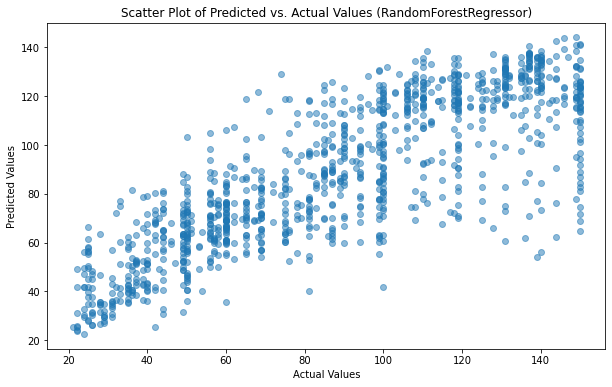

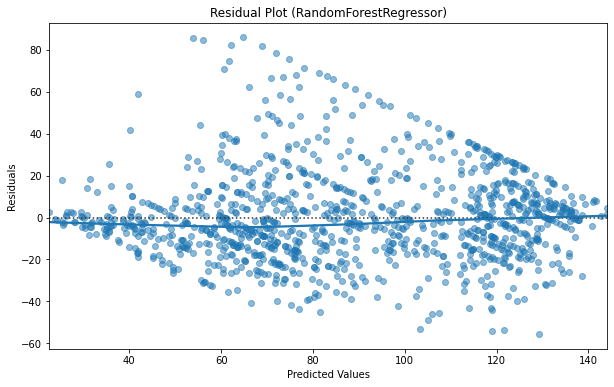

Error during modeling: 'numpy.ndarray' object has no attribute 'columns'


In [97]:
dt_model = RandomForestRegressor()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

# SVR

In [98]:
SVR_model = SVR()

# Train the model
SVR_model.fit(X_train, y_train)

# Predictions
y_train_pred = SVR_model.predict(X_train)
y_test_pred = SVR_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"SVR Train R-squared: {SVR_model.score(X_train, y_train)}")
print(f"SVR Test R-squared: {SVR_model.score(X_test, y_test)}")
print(f"SVR Train MSE: {mse_train}")
print(f"SVR Test MSE: {mse_test}")

SVR Train R-squared: 0.5530434883012527
SVR Test R-squared: 0.5292276358206933
SVR Train MSE: 627.1932259702029
SVR Test MSE: 658.6134335951764


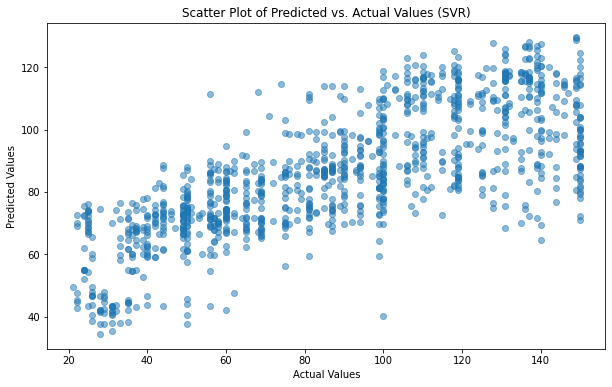

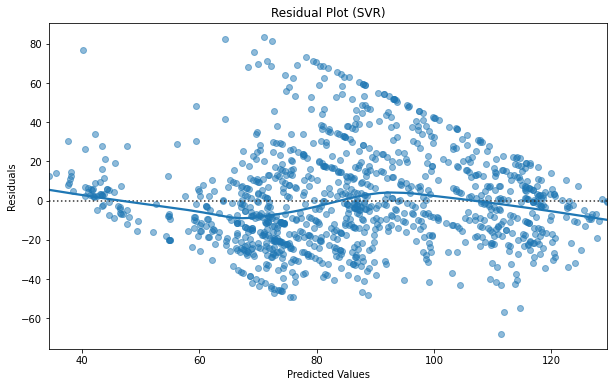

In [99]:
dt_model = SVR()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

# K-Neighbours

In [100]:
KNeighborsRegressor_model = KNeighborsRegressor()

# Train the model
KNeighborsRegressor_model.fit(X_train, y_train)

# Predictions
y_train_pred = KNeighborsRegressor_model.predict(X_train)
y_test_pred = KNeighborsRegressor_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"KNeighborsRegressor Train R-squared: {KNeighborsRegressor_model.score(X_train, y_train)}")
print(f"KNeighborsRegressor Test R-squared: {KNeighborsRegressor_model.score(X_test, y_test)}")
print(f"KNeighborsRegressor Train MSE: {mse_train}")
print(f"KNeighborsRegressor Test MSE: {mse_test}")

KNeighborsRegressor Train R-squared: 0.7769058929049025
KNeighborsRegressor Test R-squared: 0.6280213671646248
KNeighborsRegressor Train MSE: 313.05755495564983
KNeighborsRegressor Test MSE: 520.4003956834532


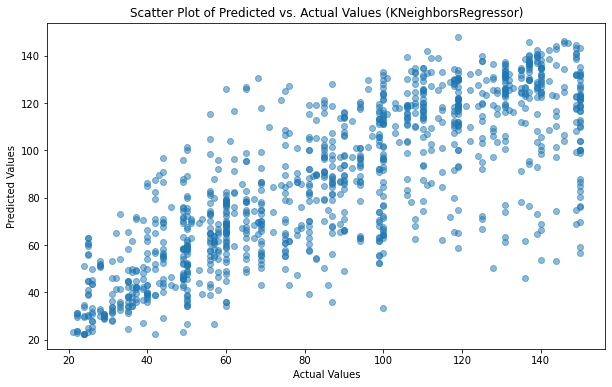

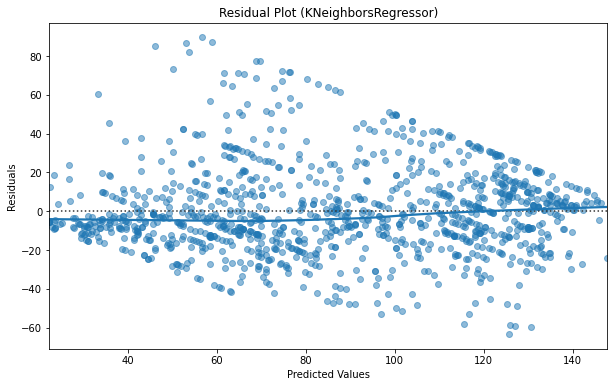

In [101]:
dt_model = KNeighborsRegressor()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

# Gradient Boost

In [102]:
GradientBoostingRegressor_model = GradientBoostingRegressor()

# Train the model
GradientBoostingRegressor_model.fit(X_train, y_train)

# Predictions
y_train_pred = GradientBoostingRegressor_model.predict(X_train)
y_test_pred = GradientBoostingRegressor_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"GradientBoostingRegressor Train R-squared: {GradientBoostingRegressor_model.score(X_train, y_train)}")
print(f"GradientBoostingRegressor Test R-squared: {GradientBoostingRegressor_model.score(X_test, y_test)}")
print(f"GradientBoostingRegressor Train MSE: {mse_train}")
print(f"GradientBoostingRegressor Test MSE: {mse_test}")

GradientBoostingRegressor Train R-squared: 0.7869254398877514
GradientBoostingRegressor Test R-squared: 0.651433044460058
GradientBoostingRegressor Train MSE: 298.9975920052305
GradientBoostingRegressor Test MSE: 487.6473151226439


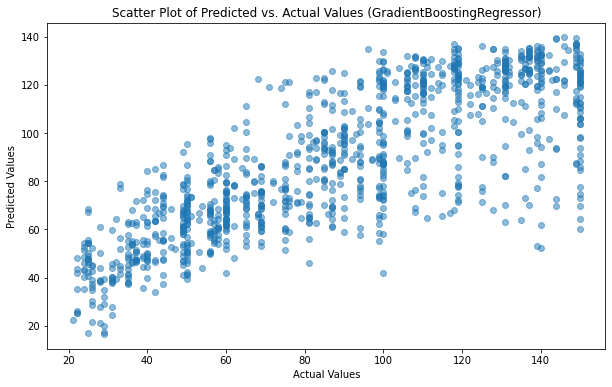

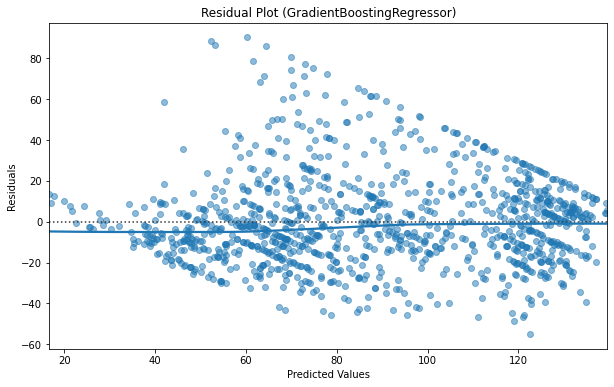

Error during modeling: 'numpy.ndarray' object has no attribute 'columns'


In [103]:
dt_model = GradientBoostingRegressor()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

# ADA Boost

In [104]:
AdaBoostRegressor_model = AdaBoostRegressor()

# Train the model
AdaBoostRegressor_model.fit(X_train, y_train)

# Predictions
y_train_pred = AdaBoostRegressor_model.predict(X_train)
y_test_pred = AdaBoostRegressor_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"AdaBoostRegressor Train R-squared: {AdaBoostRegressor_model.score(X_train, y_train)}")
print(f"AdaBoostRegressor Test R-squared: {AdaBoostRegressor_model.score(X_test, y_test)}")
print(f"AdaBoostRegressor Train MSE: {mse_train}")
print(f"AdaBoostRegressor Test MSE: {mse_test}")

AdaBoostRegressor Train R-squared: 0.5879331560898002
AdaBoostRegressor Test R-squared: 0.526574502590897
AdaBoostRegressor Train MSE: 578.2341824825967
AdaBoostRegressor Test MSE: 662.3251833052678


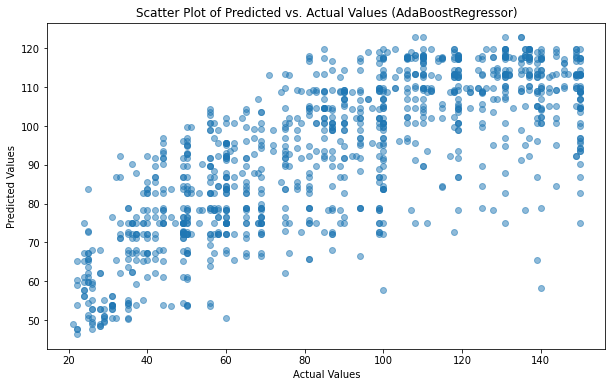

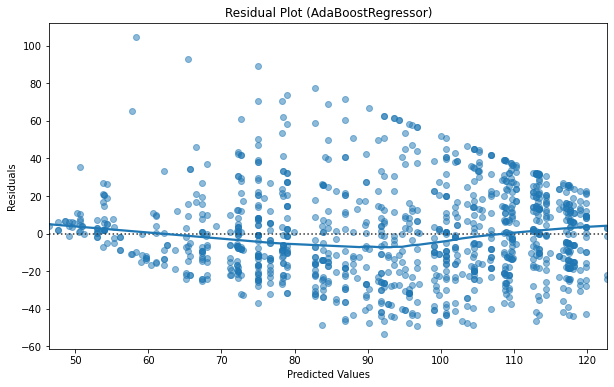

Error during modeling: 'numpy.ndarray' object has no attribute 'columns'


In [105]:
dt_model = AdaBoostRegressor()
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

# Stacking Regressors

In [106]:
StackingRegressor_model = StackingRegressor( 
        estimators=[
            ('rf', RandomForestRegressor()),
            ('la', Lasso()),
            ('ri', Ridge()),
            ('gb', GradientBoostingRegressor())
        ],
        final_estimator=LinearRegression()
    )

# Train the model
StackingRegressor_model.fit(X_train, y_train)

# Predictions
y_train_pred = StackingRegressor_model.predict(X_train)
y_test_pred = StackingRegressor_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"StackingRegressor Train R-squared: {StackingRegressor_model.score(X_train, y_train)}")
print(f"StackingRegressor Test R-squared: {StackingRegressor_model.score(X_test, y_test)}")
print(f"StackingRegressor Train MSE: {mse_train}")
print(f"StackingRegressor Test MSE: {mse_test}")

StackingRegressor Train R-squared: 0.9352470596251417
StackingRegressor Test R-squared: 0.684077757167167
StackingRegressor Train MSE: 90.86478102848822
StackingRegressor Test MSE: 441.977161220899


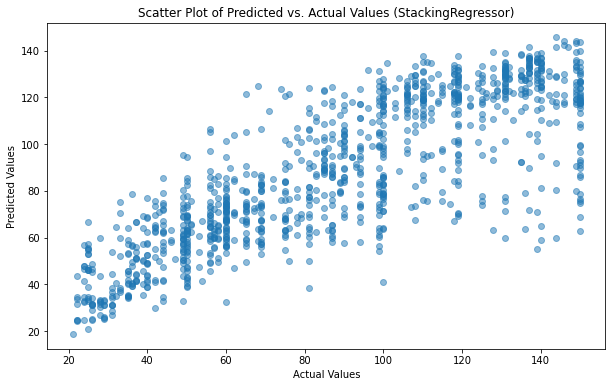

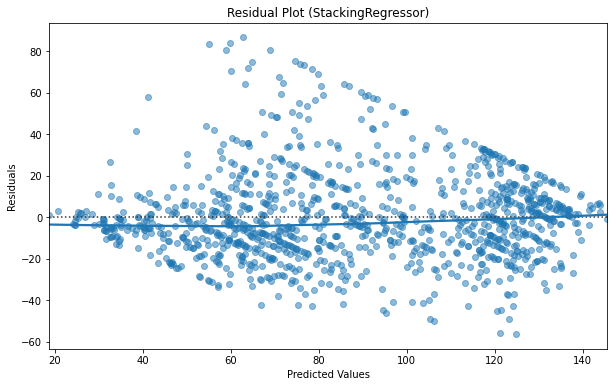

In [107]:
# Instantiate base models
rf_model = RandomForestRegressor()
lasso_model = Lasso()
ridge_model = Ridge()
gb_model = GradientBoostingRegressor()

dt_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('la', lasso_model),
        ('ri', ridge_model),
        ('gb', gb_model)
    ],
    final_estimator=LinearRegression()
)
train_predict_visualize_regressor(dt_model, X_train, X_test, y_train, y_test)

### 2.3 Evaluate and Improve the Model(s)<a id="part2.3"></a>

In [158]:
def train_and_plot(model_type, depth_range, X_train, X_test, y_train, y_test, X, y):
    # Validate input types
#     if not all(isinstance(arg, (list, range)) for arg in [depth_range, X_train, X_test, y_train, y_test, X, y]):
#         raise TypeError("Input data types are not valid")

    train_mse = []
    test_mse = []
    cross_val_train_mse = []
    cross_val_test_mse = []

    for d in depth_range:
        try:
            if model_type == 'RandomForest':
                model = RandomForestRegressor(max_depth=d, random_state=1, n_estimators=20)
            elif model_type == 'GradientBoost':
                model = GradientBoostingRegressor(max_depth=d, random_state=1, n_estimators=20)
            elif model_type == 'Ridge':
                model = Ridge(alpha=1.0)
            elif model_type == 'Lasso':
                model = Lasso(alpha=1.0)
            elif model_type == 'KNeighbors':
                model = KNeighborsRegressor(n_neighbors=5)
            else:
                raise ValueError("Invalid model type")
        except ValueError as e:
            print(f"Error creating model: {e}")
            return

        try:
            model.fit(X_train, y_train.ravel())
        except Exception as e:
            print(f"Error fitting model: {e}")
            return

        train_mse.append(mean_squared_error(model.predict(X_train), y_train))
        test_mse.append(mean_squared_error(model.predict(X_test), y_test))

        try:
            results = cross_validate(model, X, y.ravel(), scoring='neg_mean_squared_error', cv=5,
                                     return_train_score=True)
            cross_val_train_mse.append(sum(-results['train_score']) / len(results['train_score']))
            cross_val_test_mse.append(sum(-results['test_score']) / len(results['test_score']))
        except Exception as e:
            print(f"Error during cross-validation: {e}")
            return

    # Plot the simple split measures (train_mse & test_mse)
    plt.plot(depth_range, train_mse, 'bo-', label='training mse')
    plt.plot(depth_range, test_mse, 'ro-', label='testing mse')

    plt.xlabel('max_depth', fontsize='x-large')
    plt.ylabel('mean squared error (MSE)', fontsize='x-large')

    plt.legend(loc='best', shadow=True, fontsize='x-large')
    plt.show()

    # Plot the cross-validation measures (cross_val_train_mse & cross_val_test_mse)
    plt.plot(depth_range, cross_val_train_mse, 'bo-', label='cross val training mse')
    plt.plot(depth_range, cross_val_test_mse, 'ro-', label='cross val testing mse')

    plt.xlabel('max_depth', fontsize='x-large')
    plt.ylabel('mean squared error (MSE)', fontsize='x-large')

    plt.legend(loc='best', shadow=True, fontsize='x-large')
    plt.show()

In [58]:
def calculate_bias_variance(y_true, y_preds):
    # Convert y_true to a NumPy array if it's not already
    y_true = np.array(y_true)

    # Calculate mean prediction across all subsets
    mean_prediction = np.mean(y_preds, axis=0)

    # Calculate bias and variance for each data point
    bias = np.mean((y_preds - y_true[:, np.newaxis]) ** 2, axis=0)
    variance = np.mean((y_preds - mean_prediction) ** 2, axis=0)

    # Calculate total error
    total_error = bias + variance

    return bias, variance, total_error

# Lasso

In [108]:
lasso_model = Lasso(alpha=0.1)

# Train the model
lasso_model.fit(X_train, y_train)

# Predictions
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"Lasso Train R-squared: {lasso_model.score(X_train, y_train)}")
print(f"Lasso Test R-squared: {lasso_model.score(X_test, y_test)}")
print(f"Lasso Train MSE: {mse_train}")
print(f"Lasso Test MSE: {mse_test}")

Lasso Train R-squared: 0.6751104139785551
Lasso Test R-squared: 0.6272744289453618
Lasso Train MSE: 455.9024025994181
Lasso Test MSE: 521.445366847234


In [110]:
# Step 2: Define the hyperparameter search space
param_space = {
    'alpha': (1e-3, 1e3, 'log-uniform')
}

# Step 3: Bayesian Optimization
lasso = Lasso(max_iter=100000)
bayes_search = BayesSearchCV(lasso, param_space, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
bayes_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_alpha = bayes_search.best_params_['alpha']
print(f'Best Alpha: {best_alpha}')

# Step 5: Evaluate on the training set
lasso_train = Lasso(alpha=best_alpha, max_iter=100000)
lasso_train.fit(X_train, y_train)
y_train_pred = lasso_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
lasso_test = Lasso(alpha=best_alpha, max_iter=100000)
lasso_test.fit(X_train, y_train)
y_test_pred = lasso_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

Best Alpha: 0.13477223999146581
Training R-squared: 0.6730
Training Mean Squared Error: 458.7939
Test R-squared: 0.6288
Test Mean Squared Error: 519.3184


In [61]:
# Calculate bias, variance, and total error using the function
bias, variance, total_error = calculate_bias_variance(y_train, y_train_pred)

# Print the results
print(f"Bias: {np.mean(bias):.4f}")
print(f"Variance: {np.mean(variance):.4f}")
print(f"Total Error: {np.mean(total_error):.4f}")

Bias: 2319.2104
Variance: 907.1779
Total Error: 3226.3883


# Ridge

In [109]:
ridge_model = Ridge(alpha=0.1)

# Train the model
ridge_model.fit(X_train, y_train)

# Predictions
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"Ridge Train R-squared: {ridge_model.score(X_train, y_train)}")
print(f"Ridge Test R-squared: {ridge_model.score(X_test, y_test)}")
print(f"Ridge Train MSE: {mse_train}")
print(f"Ridge Test MSE: {mse_test}")

Ridge Train R-squared: 0.6794750206480277
Ridge Test R-squared: 0.619567168281528
Ridge Train MSE: 449.7777536336532
Ridge Test MSE: 532.227871929642


In [63]:
# Calculate bias, variance, and total error using the function
bias, variance, total_error = calculate_bias_variance(y_train, y_train_pred)

# Print the results
print(f"Bias: {np.mean(bias):.4f}")
print(f"Variance: {np.mean(variance):.4f}")
print(f"Total Error: {np.mean(total_error):.4f}")

Bias: 2363.7982
Variance: 951.7657
Total Error: 3315.5639


In [64]:
# Step 2: Define the hyperparameter grid
param_grid = {'alpha': np.logspace(-3, 3, 100)}

# Step 3: Grid search
lasso = Lasso(max_iter=100000)
grid_search = GridSearchCV(lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_alpha = grid_search.best_params_['alpha']
print(f'Best Alpha: {best_alpha}')

# Step 5: Evaluate on the training set
lasso_train = Lasso(alpha=best_alpha)
lasso_train.fit(X_train, y_train)
y_train_pred = lasso_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
lasso_test = Lasso(alpha=best_alpha)
lasso_test.fit(X_train, y_train)
y_test_pred = lasso_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

Best Alpha: 0.08697490026177834
Training R-squared: 0.6701
Training Mean Squared Error: 465.8009
Test R-squared: 0.6370
Test Mean Squared Error: 528.7511


In [112]:
# Step 2: Define the hyperparameter space
param_dist = {'alpha': np.logspace(-3, 3, 100)}

# Step 3: Random search
ridge = Ridge()
random_search = RandomizedSearchCV(ridge, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_alpha = random_search.best_params_['alpha']
print(f'Best Alpha: {best_alpha}')

# Step 5: Evaluate on the training set
ridge_train = Ridge(alpha=best_alpha)
ridge_train.fit(X_train, y_train)
y_train_pred = ridge_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
ridge_test = Ridge(alpha=best_alpha)
ridge_test.fit(X_train, y_train)
y_test_pred = ridge_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

Best Alpha: 284.8035868435805
Training R-squared: 0.6723
Training Mean Squared Error: 459.8778
Test R-squared: 0.6332
Test Mean Squared Error: 513.1188


In [113]:
# Step 2: Define the hyperparameter search space
param_space = {
    'alpha': (1e-3, 1e3, 'log-uniform')
}

# Step 3: Bayesian Optimization
ridge = Ridge()
bayes_search = BayesSearchCV(ridge, param_space, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
bayes_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_alpha = bayes_search.best_params_['alpha']
print(f'Best Alpha: {best_alpha}')

# Step 5: Evaluate on the training set
ridge_train = Ridge(alpha=best_alpha)
ridge_train.fit(X_train, y_train)
y_train_pred = ridge_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
ridge_test = Ridge(alpha=best_alpha)
ridge_test.fit(X_train, y_train)
y_test_pred = ridge_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

Best Alpha: 198.42794087037882
Training R-squared: 0.6743
Training Mean Squared Error: 457.0245
Test R-squared: 0.6323
Test Mean Squared Error: 514.3873


# Random Forest

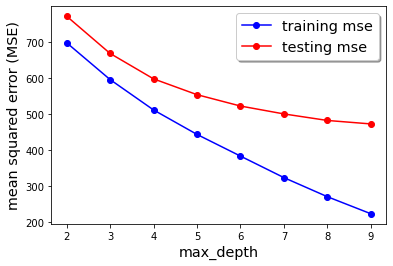

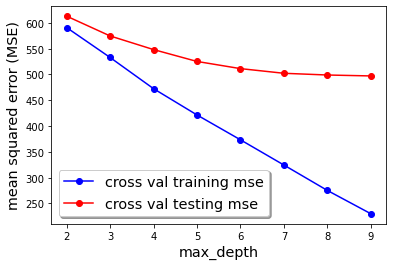

In [159]:
depth_range = range(2, 10)
train_and_plot('RandomForest', depth_range, X_train, X_test, y_train, y_test, X, y)

In [115]:
# Step 2: Define the hyperparameter distribution
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 50, num=10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Step 3: Random search
rf = RandomForestRegressor()
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Step 5: Evaluate on the training set
rf_train = RandomForestRegressor(**best_params)
rf_train.fit(X_train, y_train)
y_train_pred = rf_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
rf_test = RandomForestRegressor(**best_params)
rf_test.fit(X_train, y_train)
y_test_pred = rf_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
Training R-squared: 0.9573
Training Mean Squared Error: 59.9598
Test R-squared: 0.6757
Test Mean Squared Error: 453.7468


In [117]:
# Step 2: Define the hyperparameter search space
param_space = {
    'n_estimators': (50, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': (10, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': [True, False]
}

# Step 3: Bayesian Optimization
rf = RandomForestRegressor()
bayes_search = BayesSearchCV(rf, param_space, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
bayes_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_params = bayes_search.best_params_
print(f'Best Parameters: {best_params}')

# Step 5: Evaluate on the training set
rf_train = RandomForestRegressor(**best_params)
rf_train.fit(X_train, y_train)
y_train_pred = rf_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
rf_test = RandomForestRegressor(**best_params)
rf_test.fit(X_train, y_train)
y_test_pred = rf_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')


C:\Users\amelia\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Parameters: OrderedDict([('bootstrap', False), ('max_depth', 39), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 7), ('n_estimators', 112)])
Training R-squared: 0.9856
Training Mean Squared Error: 20.1717
Test R-squared: 0.6743
Test Mean Squared Error: 455.6510


In [118]:
# Calculate bias, variance, and total error using the function
bias, variance, total_error = calculate_bias_variance(y_train, y_train_pred)

# Print the results
print(f"Bias: {np.mean(bias):.4f}")
print(f"Variance: {np.mean(variance):.4f}")
print(f"Total Error: {np.mean(total_error):.4f}")

Bias: 2645.8292
Variance: 1242.5759
Total Error: 3888.4051


In [138]:
# Step 2: Define the hyperparameter search space
param_space = {
    'n_estimators': (50, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': (7,8),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': [True, False]
}

# Step 3: Bayesian Optimization
rf = RandomForestRegressor()
bayes_search = BayesSearchCV(rf, param_space, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
bayes_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_params = bayes_search.best_params_
print(f'Best Parameters: {best_params}')

# Step 5: Evaluate on the training set
rf_train = RandomForestRegressor(**best_params)
rf_train.fit(X_train, y_train)
y_train_pred = rf_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
rf_test = RandomForestRegressor(**best_params)
rf_test.fit(X_train, y_train)
y_test_pred = rf_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

C:\Users\amelia\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\amelia\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\amelia\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 8), ('max_features', 'auto'), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 200)])
Training R-squared: 0.8123
Training Mean Squared Error: 263.4606
Test R-squared: 0.6619
Test Mean Squared Error: 473.0205


# K-Nearest Regressor

In [139]:
# Step 2: Define the hyperparameter search space
param_space = {
    'n_estimators': (50, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': (10, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': [True, False]
}

# Step 3: Bayesian Optimization
rf = RandomForestRegressor()
bayes_search = BayesSearchCV(rf, param_space, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
bayes_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_params = bayes_search.best_params_
print(f'Best Parameters: {best_params}')

# Step 5: Evaluate on the training set
rf_train = RandomForestRegressor(**best_params)
rf_train.fit(X_train, y_train)
y_train_pred = rf_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
rf_test = RandomForestRegressor(**best_params)
rf_test.fit(X_train, y_train)
y_test_pred = rf_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')


C:\Users\amelia\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\amelia\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 50), ('max_features', 'auto'), ('min_samples_leaf', 4), ('min_samples_split', 2), ('n_estimators', 200)])
Training R-squared: 0.9219
Training Mean Squared Error: 109.5733
Test R-squared: 0.6754
Test Mean Squared Error: 454.0724


In [140]:
# Calculate bias, variance, and total error using the function
bias, variance, total_error = calculate_bias_variance(y_train, y_train_pred)

# Print the results
print(f"Bias: {np.mean(bias):.4f}")
print(f"Variance: {np.mean(variance):.4f}")
print(f"Total Error: {np.mean(total_error):.4f}")

Bias: 2464.8488
Variance: 1061.5907
Total Error: 3526.4395


In [141]:
# Step 2: Define the hyperparameter distribution
param_dist = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance (L1), 2 for Euclidean distance (L2)
}

# Step 3: Random search
knn = KNeighborsRegressor()
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Step 5: Evaluate on the training set
knn_train = KNeighborsRegressor(**best_params)
knn_train.fit(X_train, y_train)
y_train_pred = knn_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
knn_test = KNeighborsRegressor(**best_params)
knn_test.fit(X_train, y_train)
y_test_pred = knn_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 10}
Training R-squared: 1.0000
Training Mean Squared Error: 0.0000
Test R-squared: 0.6645
Test Mean Squared Error: 469.3477


# Gradient Boost

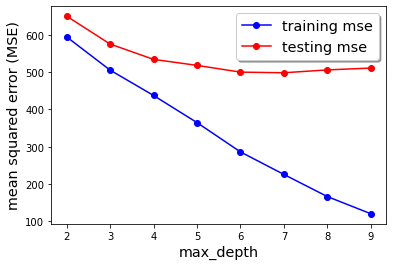

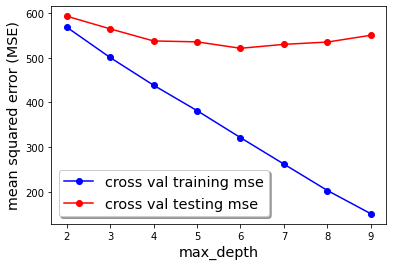

In [160]:
depth_range = range(2, 10)
train_and_plot('GradientBoost', list(depth_range), X_train, X_test, y_train, y_test, X, y)

In [143]:
# Step 2: Define the hyperparameter distribution
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=200, num=10)],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Step 3: Random search
gb = GradientBoostingRegressor()
random_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Step 5: Evaluate on the training set
gb_train = GradientBoostingRegressor(**best_params)
gb_train.fit(X_train, y_train)
y_train_pred = gb_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
gb_test = GradientBoostingRegressor(**best_params)
gb_test.fit(X_train, y_train)
y_test_pred = gb_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')


Best Parameters: {'subsample': 0.8, 'n_estimators': 116, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.1}
Training R-squared: 0.9311
Training Mean Squared Error: 96.6520
Test R-squared: 0.6768
Test Mean Squared Error: 452.1354


In [162]:
# Step 2: Define the hyperparameter search space
param_space = {
    'n_estimators': (50, 200),
    'learning_rate': (0.001, 0.3, 'log-uniform'),
    'max_depth': (5,6),
    'subsample': (0.8, 1.0),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Step 3: Bayesian Optimization
gb = GradientBoostingRegressor()
bayes_search = BayesSearchCV(gb, param_space, n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42)
bayes_search.fit(X_train, y_train)

# Step 4: Display best parameters
best_params = bayes_search.best_params_
print(f'Best Parameters: {best_params}')

# Step 5: Evaluate on the training set
gb_train = GradientBoostingRegressor(**best_params)
gb_train.fit(X_train, y_train)
y_train_pred = gb_train.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training R-squared: {train_r2:.4f}')
print(f'Training Mean Squared Error: {train_mse:.4f}')

# Step 6: Evaluate on the test set
gb_test = GradientBoostingRegressor(**best_params)
gb_test.fit(X_train, y_train)
y_test_pred = gb_test.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test R-squared: {test_r2:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

Best Parameters: OrderedDict([('learning_rate', 0.07328089075630534), ('max_depth', 6), ('max_features', 'auto'), ('min_samples_leaf', 3), ('min_samples_split', 10), ('n_estimators', 200), ('subsample', 0.8)])
Training R-squared: 0.9792
Training Mean Squared Error: 29.1367
Test R-squared: 0.6757
Test Mean Squared Error: 453.6533


In [145]:
# Calculate bias, variance, and total error using the function
bias, variance, total_error = calculate_bias_variance(y_train, y_train_pred)

# Print the results
print(f"Bias: {np.mean(bias):.4f}")
print(f"Variance: {np.mean(variance):.4f}")
print(f"Total Error: {np.mean(total_error):.4f}")

Bias: 2362.4229
Variance: 959.1695
Total Error: 3321.5924


# Stacking Regressor

In [146]:
StackingRegressor_model = StackingRegressor( 
        estimators=[
            ('rf', RandomForestRegressor()),
            ('la', Lasso(alpha=0.1, max_iter=10000)),
            ('ri', Ridge(alpha=0.1)),
            ('gb', GradientBoostingRegressor())
        ],
        final_estimator=LinearRegression()
    )

# Train the model
StackingRegressor_model.fit(X_train, y_train)

# Predictions
y_train_pred = StackingRegressor_model.predict(X_train)
y_test_pred = StackingRegressor_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"StackingRegressor Train R-squared: {StackingRegressor_model.score(X_train, y_train)}")
print(f"StackingRegressor Test R-squared: {StackingRegressor_model.score(X_test, y_test)}")
print(f"StackingRegressor Train MSE: {mse_train}")
print(f"StackingRegressor Test MSE: {mse_test}")

StackingRegressor Train R-squared: 0.9340210664233295
StackingRegressor Test R-squared: 0.6761722689787515
StackingRegressor Train MSE: 92.58516010595055
StackingRegressor Test MSE: 453.03698782965756


In [147]:
# Calculate bias, variance, and total error using the function
bias, variance, total_error = calculate_bias_variance(y_train, y_train_pred)

# Print the results
print(f"Bias: {np.mean(bias):.4f}")
print(f"Variance: {np.mean(variance):.4f}")
print(f"Total Error: {np.mean(total_error):.4f}")

Bias: 2533.1522
Variance: 1129.8980
Total Error: 3663.0503
